<a href="https://colab.research.google.com/github/Xelaro2304/MSB1015-Scientific-Programming/blob/main/Chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

## Package installation

## Import packages

In [1]:
import os
import berserk
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import re
import chess
import chess.engine

## Function definitions

In [6]:
def plot_distribution(data, plot="hist", title=None, label=None, bins=30, show_stats=True, normalize=False, log = False, alpha = 0.7):
    """
    Plot a histogram (numeric) or count plot (categorical) for a single variable.

    Parameters:
    - data: array-like, the variable to plot
    - plot: "hist" for histogram, "count" for categorical count plot
    - title: optional plot title
    - label: optional x-axis label
    - bins: number of bins for histogram (hist only)
    - show_stats: show mean/median/mode (only for histogram)
    - normalize: bool, whether to normalize frequencies/counts (0-1 or percentages)
    """
    plt.figure(figsize=(6,6))

    #Histogram plot
    if plot == "hist":
        stat_type = 'density' if normalize else 'count'
        sns.histplot(data,
                     bins=bins,
                     kde=False,
                     color=sns.color_palette("colorblind")[0],
                     stat=stat_type,
                     alpha = alpha)

        #Plot statistics

        if show_stats:
            mean_val = np.mean(data)
            median_val = np.median(data)
            mode_val = stats.mode(data, keepdims=True)[0][0]
            plt.axvline(mean_val, color=sns.color_palette("colorblind")[1], linestyle="--", linewidth=2.5, label=f"Mean = {mean_val:.2f}")
            plt.axvline(median_val, color=sns.color_palette("colorblind")[6], linestyle="--", linewidth=2.5, label=f"Median = {median_val:.2f}")
            plt.axvline(mode_val, color=sns.color_palette("colorblind")[3], linestyle="--", linewidth=2.5, label=f"Mode = {mode_val:.2f}")
            plt.legend()

        # Change to axis to log-scale
        if log:
            plt.yscale('log')

        plt.ylabel("Density" if normalize else "Frequency")
        plt.xlabel(label if label else "Value")

    #Count plot
    elif plot == "count":
        counts = data.value_counts(normalize=normalize)
        counts.plot(kind='bar', color=sns.color_palette("colorblind", len(counts)))
        plt.ylabel("Proportion" if normalize else "Count")
        plt.xlabel(label if label else "Category")

    else:
        raise ValueError("plot must be either 'hist' or 'count'")

    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_winner_by(df, col, title=None, ylabel=None):
    """
    Plot horizontal percentage-stacked bar chart for chess game results.

    Parameters:
    - df: DataFrame containing 'winner' and the numeric column.
    - col: Column name to group by (e.g., 'start_time', 'increment', 'avg_rating').
    - title: Plot title.
    - ylabel: Label for y-axis.
    """
    df_plot = df.copy()

    # Define bins
    if col == 'avg_rating':
        bins = [-np.inf, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000,
                2100, 2200, 2300, 2400, np.inf]
        labels = ["< 1000","1000-1100","1100-1200","1200-1300","1300-1400","1400-1500",
                  "1500-1600","1600-1700","1700-1800","1800-1900","1900-2000","2000-2100",
                  "2100-2200","2200-2300","2300-2400","> 2400"]
        df_plot[col] = pd.cut(df_plot[col], bins=bins, labels=labels, include_lowest=True)

    if col == 'rating_diff':
        df_plot['rating_diff_c2'] = np.where(df_plot['rating_diff'] > 0,
                                            "White higher rating", "White not-higher rating")
        # Count per category and winner
        count_df = df_plot.groupby(['rating_diff_c2', 'winner']).size().reset_index(name='count')
        count_pivot = count_df.pivot(index='rating_diff_c2', columns='winner', values='count').fillna(0)

        # Plot heatmap
        plt.figure(figsize=(8,6))
        sns.heatmap(count_pivot, annot=True, fmt='g', cmap='Greys', linewidths=0.8, linecolor='black', cbar=False,
                    annot_kws={"size": 15})
        plt.title(title if title else "Result of games by categorical difference in rating")
        plt.xlabel("Colour of winner")
        plt.ylabel("Rating before game")
        plt.show()
        return

    # Count per category and winner
    count_df = df_plot.groupby([col, 'winner']).size().reset_index(name='count')

    #Pivot for stacked percentage plot
    count_pivot = count_df.pivot(index=col, columns='winner', values='count').fillna(0)
    count_pct = count_pivot.div(count_pivot.sum(axis=1), axis=0)
    count_pct = count_pct[['white', 'draw', 'black']]  # desired stacking order

    # Define colors
    color_map = {'white': '#d9d9d9', 'draw': 'grey', 'black': 'black'}

    # Sort descending by the column
    count_pct = count_pct.sort_index(ascending=False)
    count_pivot = count_pivot.loc[count_pct.index]

    #Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    count_pct.plot(kind='barh', stacked=True,
                   color=[color_map.get(c, 'grey') for c in count_pct.columns],
                   alpha=0.95, width=1, edgecolor='black', ax=ax)

    ax.set_xlabel("Share of wins")
    ax.set_ylabel(ylabel if ylabel else col)
    ax.set_title(title if title else f"Result of games by {col}")
    ax.legend(title="Colour of winner")
    ax.xaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))

    #Add counts in the middle of each segment
    for i, val in enumerate(count_pct.index):
        left = 0
        for winner in count_pct.columns:
            frac = count_pct.loc[val, winner]
            value = count_pivot.loc[val, winner]
            if value > 0:
                text_color = 'black' if winner == 'white' else 'white'
                ax.text(left + frac/2, i, int(value), ha='center', va='center',
                        color=text_color, fontsize=12)
                left += frac

    plt.tight_layout()
    plt.show()


## Data loading

In [33]:
#Download dataset
url = 'https://docs.google.com/uc?export=download&id=1lBXYMdZtKdMm4AtGWjJFjmBygUtn8w5y&confirm=t'
path = os.getcwd()
output = path + '/games.csv'
!wget -O "{output}" "{url}"

--2025-10-19 22:26:28--  https://docs.google.com/uc?export=download&id=1lBXYMdZtKdMm4AtGWjJFjmBygUtn8w5y&confirm=t
Resolving docs.google.com (docs.google.com)... 142.250.185.206, 2a00:1450:4001:80f::200e
Connecting to docs.google.com (docs.google.com)|142.250.185.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1lBXYMdZtKdMm4AtGWjJFjmBygUtn8w5y&export=download [following]
--2025-10-19 22:26:29--  https://drive.usercontent.google.com/download?id=1lBXYMdZtKdMm4AtGWjJFjmBygUtn8w5y&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.181.225, 2a00:1450:4001:810::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.181.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7627176 (7.3M) [application/octet-stream]
Saving to: ‘/home/arojo/Documents/UM/Scientific Programming/Project/github test/MSB1015-Scien

In [34]:
#Load dataset
games_df = pd.read_csv(output, sep=';')


# Exploratory data analysis

## Initial analysis

In [35]:
games_df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,"1,50421E+17","1,50421E+17",13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,"1,50413E+17","1,50413E+17",16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,"1,50413E+17","1,50413E+17",61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,"1,50411E+17","1,50411E+17",61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,"1,50403E+17","1,50403E+17",95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [36]:
games_df.shape

(20058, 16)

In [37]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              20058 non-null  object
 1   rated           20058 non-null  bool  
 2   created_at      20058 non-null  object
 3   last_move_at    20058 non-null  object
 4   turns           20058 non-null  int64 
 5   victory_status  20058 non-null  object
 6   winner          20058 non-null  object
 7   increment_code  20058 non-null  object
 8   white_id        20058 non-null  object
 9   white_rating    20058 non-null  int64 
 10  black_id        20058 non-null  object
 11  black_rating    20058 non-null  int64 
 12  moves           20058 non-null  object
 13  opening_eco     20058 non-null  object
 14  opening_name    20058 non-null  object
 15  opening_ply     20058 non-null  int64 
dtypes: bool(1), int64(4), object(11)
memory usage: 2.3+ MB


In [38]:
games_df.isnull().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

In [39]:
games_df.describe()

,turns,white_rating,black_rating,opening_ply
count,20058.000000,20058.000000,20058.000000,20058.000000
mean,60.465999,1596.329345,1588.831987,4.816981
std,33.570585,292.907016,291.036126,2.797152
min,1.000000,-1775.000000,789.000000,1.000000
25%,37.000000,1398.000000,1391.000000,3.000000
50%,55.000000,1567.000000,1562.000000,4.000000
75%,79.000000,1793.000000,1784.000000,6.000000
max,349.000000,2700.000000,2723.000000,28.000000


## Data anomaly

Everything seems normal except for that minimum white rating, which will be inspected further

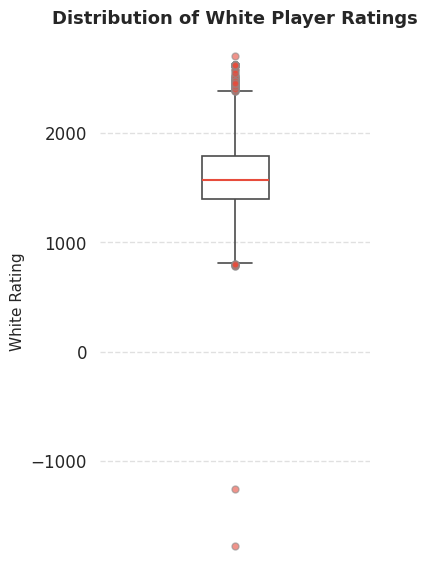

In [40]:
#Boxplot

# Style settings
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)

# Create the boxplot
plt.figure(figsize=(4, 6))
sns.boxplot(
    y=games_df['white_rating'],
    width=0.25,
    color="#EAEAEA",
    boxprops=dict(facecolor="white", edgecolor="#4C4C4C", linewidth=1.2),
    whiskerprops=dict(color="#4C4C4C", linewidth=1.2),
    capprops=dict(color="#4C4C4C", linewidth=1.2),
    medianprops=dict(color="#E74C3C", linewidth=1.5),
    flierprops=dict(marker='o', markersize=5, markerfacecolor='#E74C3C', alpha=0.6)
)

# Titles and labels
plt.title("Distribution of White Player Ratings", fontsize=13, weight='bold')
plt.ylabel("White Rating", fontsize=11)
plt.xlabel("")  # remove x-axis label
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True, bottom=True)

plt.tight_layout()

In [41]:
#Df with only negative rating games
negative_rating = games_df["white_rating"]
negative_rating = negative_rating[negative_rating < 0]
print('Number of negative values:', len(negative_rating))
negative_rating.head()

Number of negative values: 2


3287   -1259
3300   -1775
Name: white_rating, dtype: int64

There is another game with a negative value for a rating

In [42]:
negative_rating_indices = list(negative_rating.index)
negative_rating_info = games_df.iloc[list(negative_rating_indices),]
negative_rating_info.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
3287,ooJUb6U6,False,"1,4859E+16","1,4859E+16",54,resign,black,8+0,bassem8866,-1259,sollids,1704,e4 e6 Nf3 d5 Ne5 Nf6 d3 Bd6 Bg5 Bxe5 Bxf6 Qxf6...,C00,French Defense: Knight Variation,3
3300,CQguSmqj,True,"1,50402E+17","1,50402E+17",68,draw,draw,7+2,mohammad1361,-1775,katerina1965,1544,e4 e6 Nf3 d5 exd5 exd5 d4 Nf6 Nc3 Be7 Bg5 O-O ...,C00,French Defense: Knight Variation,3


Will check the original values of the game by fetching it with game ID

In [ ]:
#Connect to Lichess API
token = os.getenv("BERSERK_TOKEN")

session = berserk.TokenSession(token)

client = berserk.Client(session)


In [44]:
print(token)

lip_KUJ4WyxFB2Nmj9PqhFHy


In [45]:
negative_rating_games = list(negative_rating_info["id"])
corrected_ratings = []
for g in negative_rating_games:
    game = client.games.export(g, as_pgn=True)
    print(game)
    game = game.split('\n')
    corrected_ratings.append(int(game[9][11:15]))
print(corrected_ratings)

[Event "casual rapid game"]
[Site "https://lichess.org/ooJUb6U6"]
[Date "2017.01.31"]
[White "Bassem8866"]
[Black "Sollids"]
[Result "0-1"]
[GameId "ooJUb6U6"]
[UTCDate "2017.01.31"]
[UTCTime "20:36:43"]
[WhiteElo "1259"]
[BlackElo "1704"]
[Variant "Standard"]
[TimeControl "480+0"]
[ECO "C00"]
[Opening "French Defense: Knight Variation"]
[Termination "Normal"]

1. e4 e6 2. Nf3 d5 3. Ne5 Nf6 4. d3 Bd6 5. Bg5 Bxe5 6. Bxf6 Qxf6 7. Nc3 Bxc3+ 8. bxc3 Qxc3+ 9. Ke2 Nc6 10. Qd2 Qxa1 11. Qg5 Nd4+ 12. Ke3 Qc1+ 13. Kxd4 Qxg5 14. f3 b6 15. exd5 Qxd5+ 16. Ke3 Qc5+ 17. d4 Qc3+ 18. Bd3 O-O 19. h4 e5 20. h5 Qxd4+ 21. Kd2 Qf2+ 22. Kc3 Rd8 23. h6 gxh6 24. Rxh6 Qd4+ 25. Kd2 Qf4+ 26. Ke2 Qxh6 27. Be4 Qd2+ 0-1



[Event "afiqasyraf Arena"]
[Site "https://lichess.org/CQguSmqj"]
[Date "2017.08.29"]
[White "mohammad1361"]
[Black "Katerina1965"]
[Result "1/2-1/2"]
[GameId "CQguSmqj"]
[UTCDate "2017.08.29"]
[UTCTime "15:38:25"]
[WhiteElo "1775"]
[BlackElo "1544"]
[WhiteRatingDiff "-7"]
[BlackRatingDiff "+6"]
[V

In [46]:
#Correct ratings
games_positive_rtg = games_df.copy()
games_positive_rtg.loc[negative_rating_indices, 'white_rating'] = corrected_ratings
games_positive_rtg.loc[negative_rating_indices]

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
3287,ooJUb6U6,False,"1,4859E+16","1,4859E+16",54,resign,black,8+0,bassem8866,1259,sollids,1704,e4 e6 Nf3 d5 Ne5 Nf6 d3 Bd6 Bg5 Bxe5 Bxf6 Qxf6...,C00,French Defense: Knight Variation,3
3300,CQguSmqj,True,"1,50402E+17","1,50402E+17",68,draw,draw,7+2,mohammad1361,1775,katerina1965,1544,e4 e6 Nf3 d5 exd5 exd5 d4 Nf6 Nc3 Be7 Bg5 O-O ...,C00,French Defense: Knight Variation,3


## Data report

In [ ]:
Make report of dataframe
profile = ProfileReport(games_df,title="Games report")

profile.to_file("games_report.html")


In [ ]:
#Display report
from IPython.display import HTML

# show an HTML file inside the notebook
HTML(filename="games_report.html")

## Player ratings


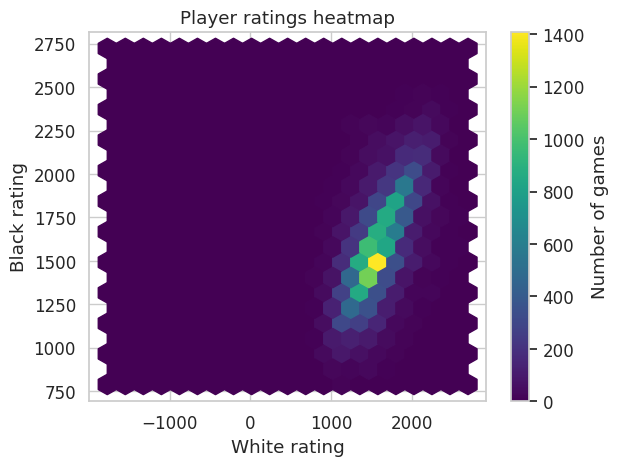

In [49]:
plt.hexbin(games_df['white_rating'], games_df['black_rating'], gridsize=20, cmap='viridis')
plt.colorbar(label="Number of games")
plt.xlabel("White rating")
plt.ylabel("Black rating")
plt.title("Player ratings heatmap")
plt.show()


## Average ratings

/tmp/ipykernel_23173/401206534.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = df_plot.groupby([col, 'winner']).size().reset_index(name='count')


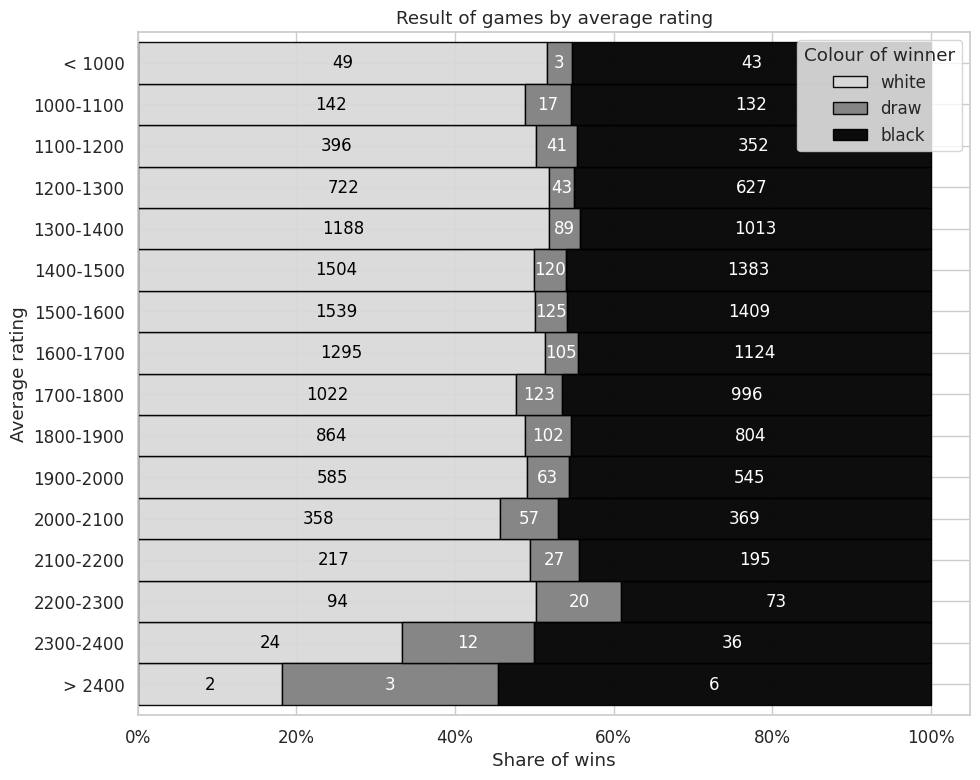

In [50]:
# Average rating
avg_rating = games_df
games_df['avg_rating'] = (games_df['white_rating'] + games_df['black_rating']) / 2
plot_winner_by(games_df, 'avg_rating', title="Result of games by average rating", ylabel="Average rating")


## Exploratory analysis conclusions

Things to notice:

1.   There seem to be some duplicated instances
1.   There are 400 unique increment codes, which seems problematic to use for classification
2.   The number of draws in winner is higher than the number of draws in victory status, will need to check that
1.   Winner classes are somewhat balanced, except for the amount of draws











# Preprocessing

## Duplicated instances

Number of unique records: 19113
Total number of duplicated records: 1758
Number of records duplicated: 813
Duplicated ids: ['XRuQPSzH', 'Q0jogkvi', 'CxQlHSnq', 'O037dETy', 'CvakmVNb', 'LyRqbD4d', 'DijZlfMy', 'I8odmGjb', 'ZPHBiKBY', 'QurxyQkA', '1b0kpInt', 'UvqLtnPM', 'VgNt0SSX', 'o4T7dj5h', 'h0YsGMhj', 'nyYULwUl', 'j5KY62yS', 'dJEtAQp7', 'facMwkUo', 'edYOVb5F', 'GstYv2mJ', 'dFQ5D7CS', 'igSDFKv0', 't7vvcwqO', '0gTDO6Av', 'mJ9VpdxV', 'qAjnQuMs', 'rqcPeu3M', 'OeIyJzKT', '5JlKibRN', 'SUWEHMFw', 'doUy4nEv', 'EsroTMo9', 'QD32OPEC', '6M0gH6Hy', 'a3IM5ZlR', 'mQmeRjep', 'BTWBBxuj', 'zZK6BQrf', '8iCBDNOc', 'bHXgtlis', '9SLJdD3l', 'jPu5u90q', 'G2fnVSUC', '4bLQaDKI', 'LlI2vr6r', 'JfT9yIBl', 'wgIHzqDo', 'w7Jan8kW', 'C78mg5wI', 'VCm6Y9sa', 'VW8jn694', 'ZWXisimD', 'LmAF9EOQ', 'qUetu3Fa', '1GJI8zgp', '1vZFGZU4', 'orGL4RMu', '5ORW5WNC', 'Bys3Uii4', '6XdCEkkJ', 'VCvbNgko', 'ZSUzhRPE', 'bGiGLLkt', 'c4xul4aH', 'ILxgRGiu', 'XNMbvz8v', '4qRYXCHX', '2shZQ2X6', 'mu5KYglJ', 'MP8TYTbX', '8CCBHpef', 'khJOZetm', 

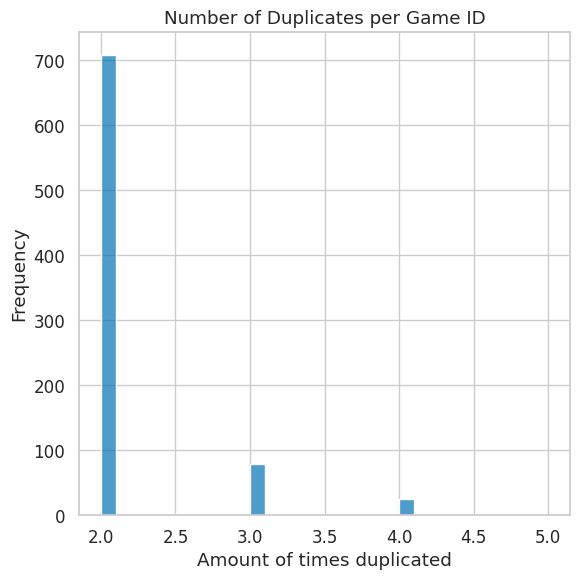

In [51]:
import matplotlib.pyplot as plt
from scipy import stats

game_ids = games_positive_rtg['id']
print('Number of unique records:', len(games_positive_rtg['id'].unique()))
duplicate_counts = games_positive_rtg['id'].value_counts()
duplicate_ids = list(duplicate_counts[duplicate_counts > 1].index)
duplicate_counts = duplicate_counts[duplicate_counts > 1]
print('Total number of duplicated records:', sum(duplicate_counts))
print('Number of records duplicated:', len(duplicate_counts))
print('Duplicated ids:', duplicate_ids)

plot_distribution(duplicate_counts.values, 'hist', 'Number of Duplicates per Game ID', 'Amount of times duplicated', show_stats=False)


Out of the 20,058 records, 19113 are unique, but it is detecting only 813 replicates instead of 945

Repetition is mainly occuring in duplicates, although some of them are repeated 3-5 times

In [52]:
#Remove duplicates
games_unique = games_positive_rtg.drop_duplicates(keep='first')
print(f"Original rows: {len(games_positive_rtg)}, After removing duplicates: {len(games_unique)}")

Original rows: 20058, After removing duplicates: 19629


Trying to remove duplicates values only removes ~400 of them, so I'll inspect further

In [53]:
duplicate_sample = games_positive_rtg[games_positive_rtg['id'].isin(duplicate_ids[0:4])]
duplicate_sample.sort_values(by='id')

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
210,CxQlHSnq,False,"1,50374E+17","1,50374E+17",66,resign,black,7+2,striker123,1806,taranga,1289,e4 e5 Nf3 Nc6 d4 d6 dxe5 Nxe5 Nxe5 dxe5 Qxd8+ ...,C44,Scotch Game,5
11437,CxQlHSnq,False,"1,50374E+12","1,50374E+12",66,resign,black,7+2,striker123,1806,taranga,1289,e4 e5 Nf3 Nc6 d4 d6 dxe5 Nxe5 Nxe5 dxe5 Qxd8+ ...,C44,Scotch Game,5
19085,CxQlHSnq,False,"1,50374E+12","1,50374E+12",66,resign,black,7+2,striker123,1806,taranga,1289,e4 e5 Nf3 Nc6 d4 d6 dxe5 Nxe5 Nxe5 dxe5 Qxd8+ ...,C44,Scotch Game,5
13764,CxQlHSnq,False,"1,50374E+12","1,50374E+12",66,resign,black,7+2,striker123,1806,taranga,1289,e4 e5 Nf3 Nc6 d4 d6 dxe5 Nxe5 Nxe5 dxe5 Qxd8+ ...,C44,Scotch Game,5
209,O037dETy,False,"1,50374E+17","1,50374E+17",60,resign,black,7+2,taranga,1289,armourbuddy,1810,e4 c5 Nf3 g6 d4 cxd4 Nxd4 Bg7 Nc3 a6 Bc4 e6 Bf...,A42,Sicilian Defense: Hyperaccelerated Fianchetto,5
19084,O037dETy,False,"1,50374E+12","1,50374E+12",60,resign,black,7+2,taranga,1289,armourbuddy,1810,e4 c5 Nf3 g6 d4 cxd4 Nxd4 Bg7 Nc3 a6 Bc4 e6 Bf...,A42,Sicilian Defense: Hyperaccelerated Fianchetto,5
11436,O037dETy,False,"1,50374E+12","1,50374E+12",60,resign,black,7+2,taranga,1289,armourbuddy,1810,e4 c5 Nf3 g6 d4 cxd4 Nxd4 Bg7 Nc3 a6 Bc4 e6 Bf...,A42,Sicilian Defense: Hyperaccelerated Fianchetto,5
13763,O037dETy,False,"1,50374E+12","1,50374E+12",60,resign,black,7+2,taranga,1289,armourbuddy,1810,e4 c5 Nf3 g6 d4 cxd4 Nxd4 Bg7 Nc3 a6 Bc4 e6 Bf...,A42,Sicilian Defense: Hyperaccelerated Fianchetto,5
19086,Q0jogkvi,False,"1,50368E+12","1,50368E+12",21,outoftime,white,5+8,taranga,1289,snapper,1500,e4 e5 Nf3 d6 Bc4 h6 Nc3 Bg4 h3 Bh5 d3 c6 Be3 N...,C41,Philidor Defense #3,5
211,Q0jogkvi,False,"1,50368E+17","1,50368E+17",21,outoftime,white,5+8,taranga,1289,snapper,1500,e4 e5 Nf3 d6 Bc4 h6 Nc3 Bg4 h3 Bh5 d3 c6 Be3 N...,C41,Philidor Defense #3,5


Some of the repeated instances have distinct values of "created_at" and "last_move_at", so I'll try removing it

In [54]:
#Remove creation time and last move columns
games_time_dropped = games_positive_rtg.drop(columns=['created_at', 'last_move_at'])

#Remove duplicates
games_unique = games_time_dropped.drop_duplicates(keep='first').reset_index(drop=True)
print(f"Original rows: {len(games_time_dropped)}, After removing duplicates: {len(games_unique)}")

Original rows: 20058, After removing duplicates: 19113


All duplicates removed

## Convert increment codes

I'll try to handle the increment code in two ways:


1.   Separate time into minutes and time increment per move
2.   Classify each increment code into a time control



### Convert into initial time and increment move

In [55]:
increment_code = games_unique['increment_code']
increment_code_split = [time.split('+') for time in increment_code]
print('Splitted increment codes:', increment_code_split)

#As minutes and increment

#Initial time
start_time = [int(minutes[0]) for minutes in increment_code_split]
print('Starting time in minutes:', start_time)

#Increment
increment = [int(seconds[1]) for seconds in increment_code_split]
print('Increment in seconds:', increment)



Splitted increment codes: [['15', '2'], ['5', '10'], ['5', '10'], ['20', '0'], ['30', '3'], ['10', '0'], ['10', '0'], ['15', '30'], ['15', '0'], ['10', '0'], ['20', '60'], ['20', '60'], ['5', '40'], ['8', '0'], ['15', '15'], ['15', '15'], ['15', '15'], ['15', '16'], ['15', '15'], ['11', '0'], ['15', '15'], ['30', '60'], ['15', '5'], ['10', '0'], ['10', '0'], ['10', '10'], ['10', '10'], ['10', '10'], ['10', '10'], ['10', '10'], ['10', '10'], ['10', '10'], ['10', '10'], ['15', '3'], ['18', '0'], ['10', '0'], ['10', '0'], ['15', '0'], ['15', '0'], ['30', '30'], ['20', '25'], ['5', '5'], ['30', '0'], ['40', '40'], ['20', '0'], ['15', '0'], ['15', '0'], ['10', '0'], ['40', '40'], ['40', '40'], ['10', '0'], ['10', '0'], ['10', '0'], ['10', '0'], ['16', '0'], ['6', '10'], ['10', '0'], ['10', '0'], ['10', '0'], ['10', '0'], ['8', '10'], ['8', '12'], ['8', '12'], ['8', '12'], ['5', '10'], ['7', '12'], ['15', '10'], ['5', '40'], ['15', '5'], ['20', '5'], ['20', '5'], ['20', '5'], ['20', '5'], ['

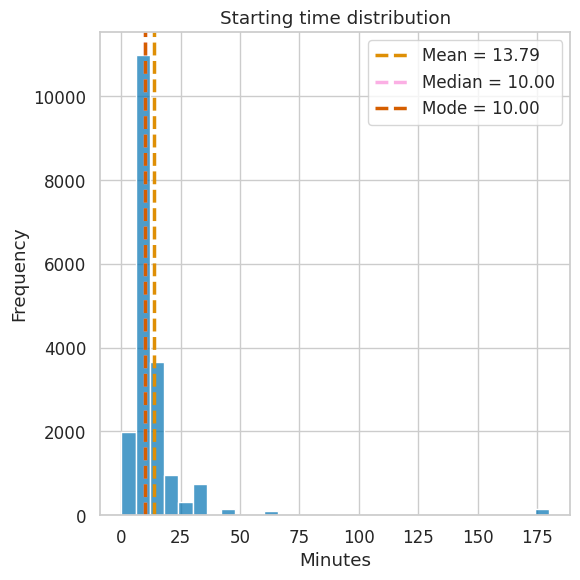

In [56]:
plot_distribution(start_time, 'hist', 'Starting time distribution', 'Minutes', show_stats=True)

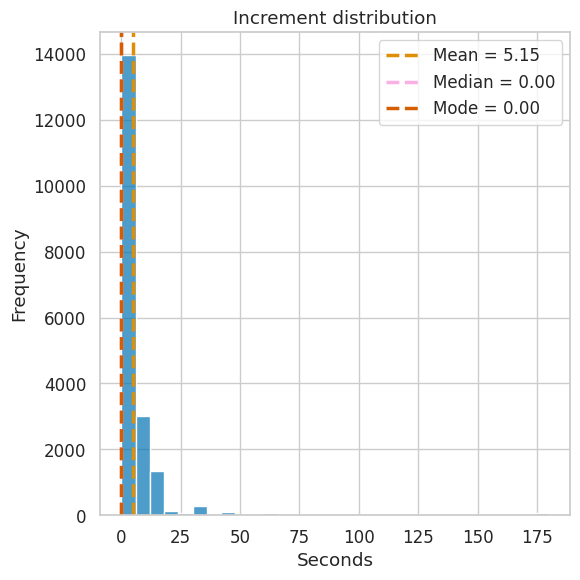

In [57]:
plot_distribution(increment, 'hist', 'Increment distribution', 'Seconds', show_stats=True)

In [58]:
start_time_df = pd.DataFrame(start_time, columns=['start_time'])
increment_df = pd.DataFrame(increment, columns=['increment'])
#check if there are games with 0 < start time < 1
under_minute = ((start_time_df < 1) & (start_time_df > 0)).sum()
print('Games with less than 1 minute of start time:', under_minute.iloc[0])


Games with less than 1 minute of start time: 0


Most games are finish (no increment) and have 10 minutes as start time, with no game starting with less than a minute

In [59]:
#Add new features to df
games_unique = pd.concat([games_unique, start_time_df], axis = 1)
games_unique = pd.concat([games_unique, increment_df], axis = 1)
games_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19113 entries, 0 to 19112
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              19113 non-null  object
 1   rated           19113 non-null  bool  
 2   turns           19113 non-null  int64 
 3   victory_status  19113 non-null  object
 4   winner          19113 non-null  object
 5   increment_code  19113 non-null  object
 6   white_id        19113 non-null  object
 7   white_rating    19113 non-null  int64 
 8   black_id        19113 non-null  object
 9   black_rating    19113 non-null  int64 
 10  moves           19113 non-null  object
 11  opening_eco     19113 non-null  object
 12  opening_name    19113 non-null  object
 13  opening_ply     19113 non-null  int64 
 14  start_time      19113 non-null  int64 
 15  increment       19113 non-null  int64 
dtypes: bool(1), int64(6), object(9)
memory usage: 2.2+ MB


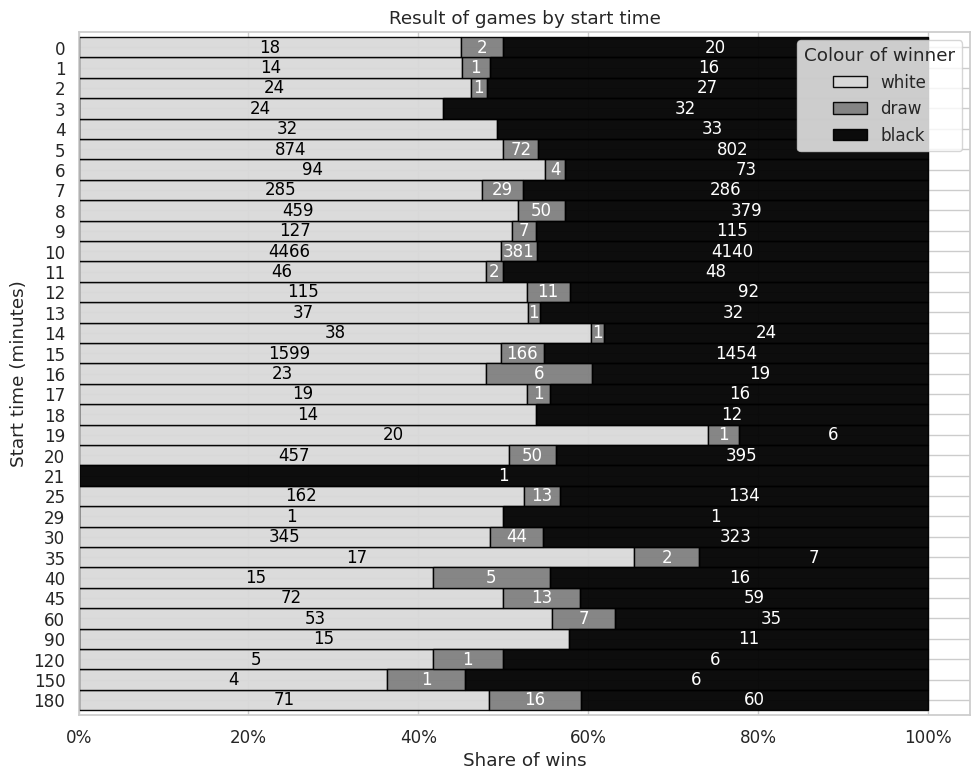

In [60]:
plot_winner_by(games_unique, 'start_time', title="Result of games by start time", ylabel="Start time (minutes)")

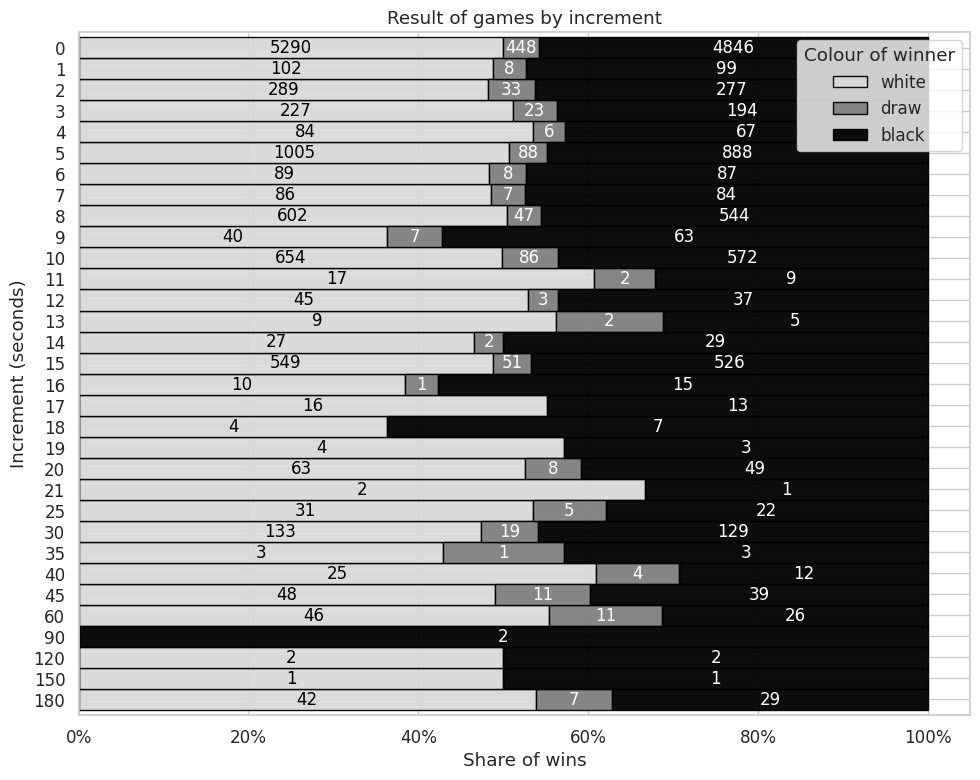

In [61]:
plot_winner_by(games_unique, 'increment', title="Result of games by increment", ylabel="Increment (seconds)")


### Convert into increment codes

According to the data source, [Lichess](https://lichess.org/faq#time-controls), time controls are decided assuming a game length of 40 moves and assigning the following categories depending on the duration:

    ≤ 29s = UltraBullet
    ≤ 179s = Bullet
    ≤ 479s = Blitz
    ≤ 1499s = Rapid
    ≥ 1500s = Classical

In [62]:
def set_time_control(minutes, increment):
    """
    Set time control considering a 40 move game length
    minutes: Int, initial time of game
    increment: Int, time added per move
    """
    total_time = minutes*60+increment*40
    if total_time <= 29:
        return 'UltraBullet'
    elif total_time <= 179:
        return 'Bullet'
    elif total_time <= 479:
        return 'Blitz'
    elif total_time <= 1499:
        return 'Rapid'
    else:
        return 'Classical'

time_control = games_unique.apply(lambda x: set_time_control(x['start_time'], x['increment']), axis=1)
time_control_df = pd.DataFrame({'time_control': time_control})
time_control_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19113 entries, 0 to 19112
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   time_control  19113 non-null  object
dtypes: object(1)
memory usage: 149.4+ KB


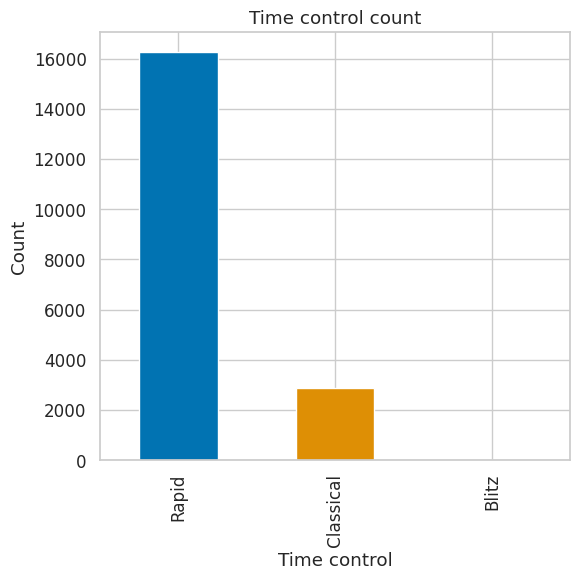

In [63]:
plot_distribution(time_control, "count",'Time control count', 'Time control')

Too few blitz games to the point they are not even appreciated

In [64]:
blitz = [i for i in time_control if i == 'Blitz']
print('Number of blitz games:', len(blitz))

Number of blitz games: 4


Very few blitz games
Since there are too few it would cause troubles during the training and testing, so I dont consider this approach to be viable any longer and will not proceed with it

## Analysis of drawed games

Accordint to the stats report, not all games with a winner status of draw have a winner value of draw

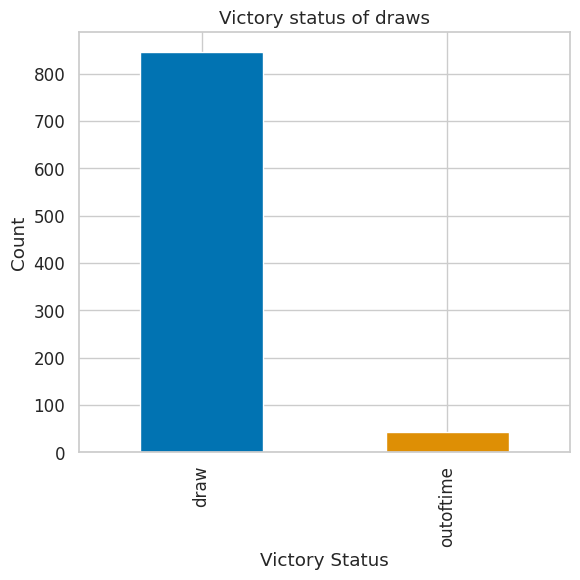

In [65]:
#Analyze drawed games
draws = games_unique[['victory_status','winner']]
draws = draws[games_unique['winner'] == 'draw']
not_draw = draws[draws['victory_status'] != 'draw']
plot_distribution(draws['victory_status'], 'count', 'Victory status of draws', 'Victory Status')

The alternative victory status  of drawed games is out of time, which makes sense since the game can result in a draw by insufficient winning material even when running out of time, so it is not a recording error

## Rating difference

I will also add the rating difference as a feature to see if it is useful for the predictions

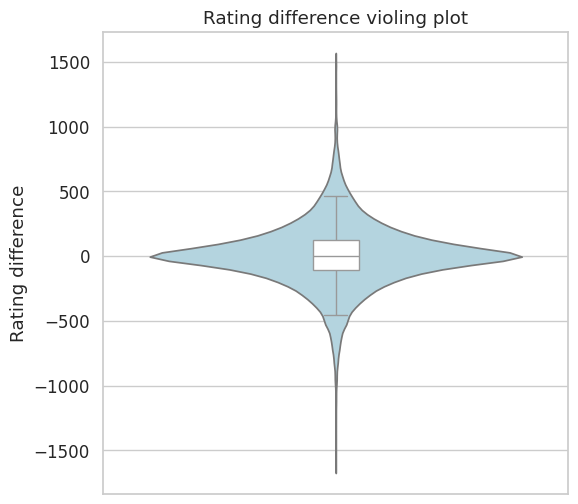

In [66]:
#Rating difference
games_unique['rating_diff'] = games_unique['white_rating'] - games_unique['black_rating']

plt.figure(figsize=(6, 6))

# Violin plot with boxplot and points
sns.violinplot(y=games_unique['rating_diff'], inner=None, color="lightblue")  # violin
sns.boxplot(y=games_unique['rating_diff'], width=0.1, color="white", fliersize=0)

plt.title("Rating difference violing plot")
plt.ylabel("Rating difference")
plt.show()

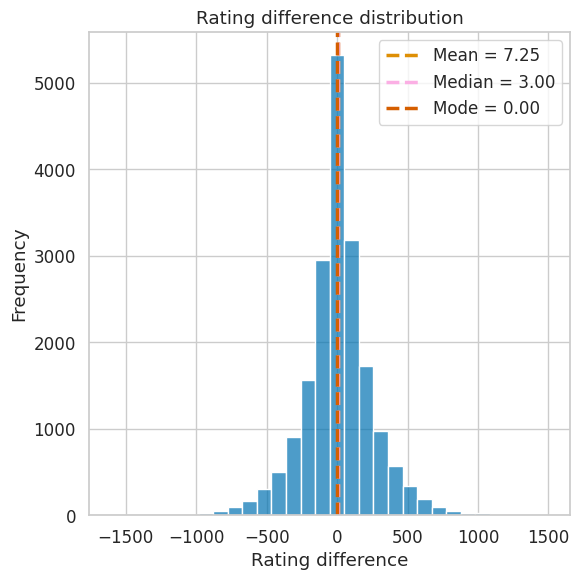

In [67]:
plot_distribution(games_unique['rating_diff'], 'hist', 'Rating difference distribution', 'Rating difference', show_stats=True)

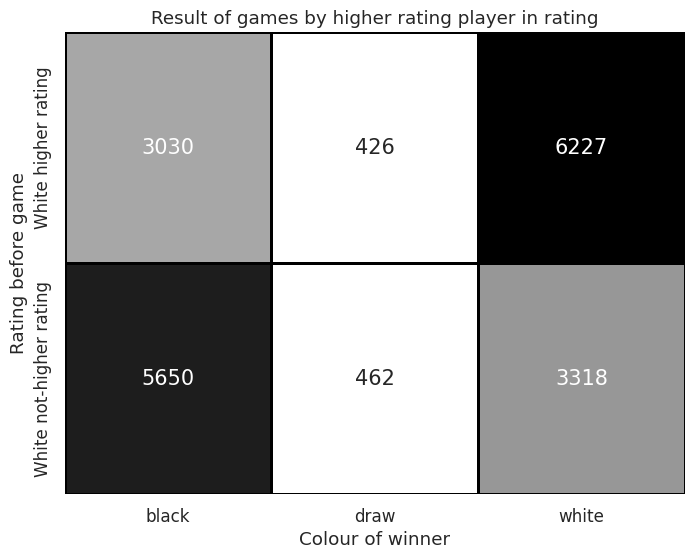

In [68]:
# Categorical rating difference
plot_winner_by(games_unique, 'rating_diff', title="Result of games by higher rating player in rating")

## Game Evaluation

Finally,as a simple approach to implement game information I am getting the evaluation of the position during the middle game from the algebraic notation of the game

### Removal of short games

To avoid having a short game in which one of the players made a sudden abandonment or ran out of time I will filter all the games that did not reach left the opening phase and not entered the middle game

While there is no clear division between the end of the opening and the start of the middle game, I will assume that middlegame starts after move 15 (30 turns) and remove games shorter than 20 moves to allow some middle game play

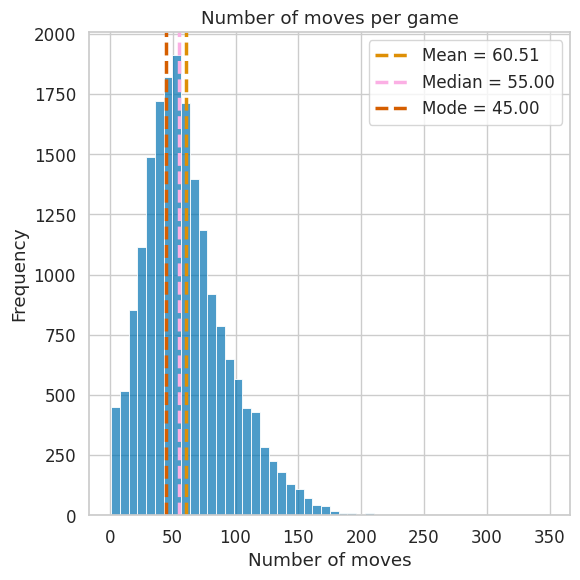

In [69]:
plot_distribution(games_unique['turns'], 'hist', 'Number of moves per game', 'Number of moves', bins=50)

In [70]:
# Keep only rows with at least 40 turns
games_long = games_unique.copy()
games_long = games_long[games_long['turns'] >= 40]

games_long = games_long.reset_index(drop=True)
games_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13727 entries, 0 to 13726
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              13727 non-null  object
 1   rated           13727 non-null  bool  
 2   turns           13727 non-null  int64 
 3   victory_status  13727 non-null  object
 4   winner          13727 non-null  object
 5   increment_code  13727 non-null  object
 6   white_id        13727 non-null  object
 7   white_rating    13727 non-null  int64 
 8   black_id        13727 non-null  object
 9   black_rating    13727 non-null  int64 
 10  moves           13727 non-null  object
 11  opening_eco     13727 non-null  object
 12  opening_name    13727 non-null  object
 13  opening_ply     13727 non-null  int64 
 14  start_time      13727 non-null  int64 
 15  increment       13727 non-null  int64 
 16  rating_diff     13727 non-null  int64 
dtypes: bool(1), int64(7), object(9)
memory usage: 1.7+

### Game evaluation

In [71]:
#Load engine (Stockfish)
engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")
def game_eval(moves, idx=None, move_number=20, depth=10):
    """
    Evaluate final position from White's perspective (positive = White better)
    as centipawn evaluation. Handles notation cleanup, invalid moves,
    and malformed strings.
    """

    #Print when 100 games have been analyzed
    if idx is not None and idx % 100 == 0:
        print(f"{idx} rows analyzed")

    # Clean move text: remove numbers, results, and dots
    moves = re.sub(r"\d+\.", "", moves)
    moves = re.sub(r"(1-0|0-1|1/2-1/2|\*)", "", moves)
    moves = moves.strip()

    board = chess.Board()
    target_plies = move_number * 2  # each move = 2 half-moves
    count = 0

    # Try to play all moves
    for move in moves.split():
        try:
            board.push_san(move)
            count += 1
        except Exception:
            # If illegal move return none
            return None

        if count >= target_plies:
            break

    # Run engine analysis
    info = engine.analyse(board, chess.engine.Limit(depth=depth))
    score = info["score"].pov(chess.WHITE).score(mate_score=20000)
    return score

#Evaluate games
games_processed = games_long.copy()
games_processed[f"evaluation"] = [
    game_eval(moves, idx=i) for i, moves in enumerate(games_processed["moves"])
]
engine.quit()
games_processed.head()

FileNotFoundError: [Errno 2] No such file or directory: '/usr/games/stockfish'

The preprocessed dataset is available for download if needed

In [4]:

#Download dataset
url = 'https://docs.google.com/uc?export=download&id=1mzcs6NwLUS5mbmPEhgEClJQcjK7kvNnh&confirm=t'
path = os.getcwd()
output = path + '/games_processed.csv'
!wget -O "{output}" "{url}"

games_processed = pd.read_csv(output, sep=';')


--2025-10-19 22:39:32--  https://docs.google.com/uc?export=download&id=1mzcs6NwLUS5mbmPEhgEClJQcjK7kvNnh&confirm=t
Resolving docs.google.com (docs.google.com)... 172.217.18.14, 2a00:1450:4001:80b::200e
Connecting to docs.google.com (docs.google.com)|172.217.18.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1mzcs6NwLUS5mbmPEhgEClJQcjK7kvNnh&export=download [following]
--2025-10-19 22:39:32--  https://drive.usercontent.google.com/download?id=1mzcs6NwLUS5mbmPEhgEClJQcjK7kvNnh&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.181.225, 2a00:1450:4001:82f::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.181.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5721688 (5.5M) [application/octet-stream]
Saving to: ‘/home/arojo/Documents/UM/Scientific Programming/Project/github test/MSB1015-Scientifi

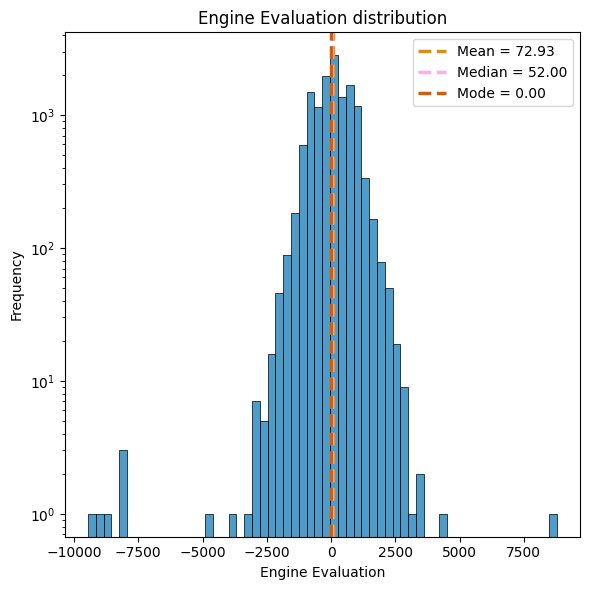

In [7]:
plot_distribution(games_processed['evaluation'], 'hist', 'Engine Evaluation distribution', 'Engine Evaluation', bins = 60, log =True)

Games with absolute evaluation of ~20k would lead to data leakage since it is a way to interpret the result of a game, so they will be removed

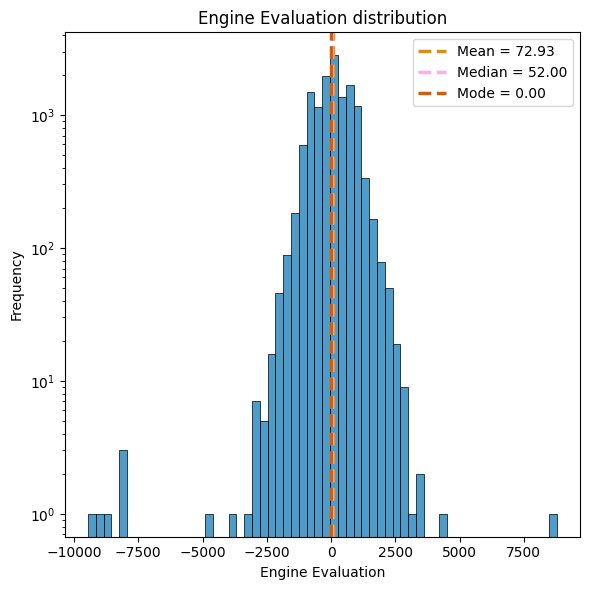

In [8]:
#Remove games with checkmate evaluation
games_processed = games_processed[games_processed['evaluation'].between(-10000, 10000)]
games_processed = games_processed.reset_index(drop=True)
plot_distribution(games_processed['evaluation'], 'hist', 'Engine Evaluation distribution', 'Engine Evaluation', bins = 60, log =True)

/tmp/ipykernel_26286/3165584066.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


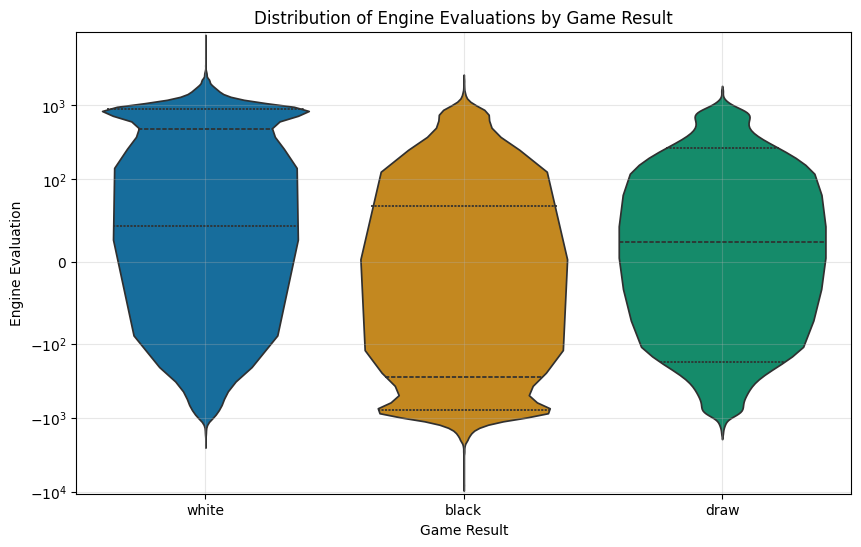

In [9]:
#Visualize distribution by result
plt.figure(figsize=(10,6))
sns.violinplot(
    x='winner',
    y='evaluation',
    data=games_processed,
    inner='quartile',
    palette='colorblind'
)
plt.yscale('symlog', linthresh=100)
plt.xlabel('Game Result')
plt.ylabel('Engine Evaluation')
plt.title('Distribution of Engine Evaluations by Game Result')
plt.grid(True, alpha=0.3)
plt.show()

## Repeat exploratory analysis

In [10]:
#Visualize report after the preprocessing
#profile = ProfileReport(games_processed,title="Games after processing report")
#profile.to_file("games_processed_report.html")
#HTML(filename="games_processed_report.html")

# Modelling

## Data split

Drop unused features

In [11]:
games_selected = games_processed.drop(['id',
                                        'turns',
                                        'increment_code',
                                        'victory_status',
                                        'white_id',
                                        'black_id',
                                        'moves',
                                        'opening_eco',
                                        'opening_name',
                                        'opening_ply'], axis = 1)

In [12]:
from sklearn.model_selection import train_test_split

def define_train_test(df):
    #Defines predictors and class variable and returns the train and test datasets

    #Define target variable
    target = 'winner'
    y = df[target]
    X = df.drop(target, axis = 1)

    #80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

    print('Shape of Data (20%)')
    print("X_train shape : ", X_train.shape)
    print("y_train shape : ", y_train.shape)
    print("X_test shape : ", X_test.shape)
    print("y_test shape : ", y_test.shape)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = define_train_test(games_selected)

Shape of Data (20%)
X_train shape :  (10592, 7)
y_train shape :  (10592,)
X_test shape :  (2649, 7)
y_test shape :  (2649,)


In [13]:
games_selected.info()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13241 entries, 0 to 13240
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rated         13241 non-null  bool  
 1   winner        13241 non-null  object
 2   white_rating  13241 non-null  int64 
 3   black_rating  13241 non-null  int64 
 4   start_time    13241 non-null  int64 
 5   increment     13241 non-null  int64 
 6   rating_diff   13241 non-null  int64 
 7   evaluation    13241 non-null  int64 
dtypes: bool(1), int64(6), object(1)
memory usage: 737.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 10592 entries, 7463 to 10410
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   rated         10592 non-null  bool 
 1   white_rating  10592 non-null  int64
 2   black_rating  10592 non-null  int64
 3   start_time    10592 non-null  int64
 4   increment     10592 non-null  int64
 5   rating_diff  

## Encoding

In [14]:
from sklearn.preprocessing import LabelEncoder

def encode (y_tra, y_te):
    #Encodes label df while also returning the encoder
    encoder = LabelEncoder()
    y_tra = encoder.fit_transform(y_tra)
    y_te = encoder.transform(y_te)
    return y_tra, y_te, encoder

y_train, y_test, le = encode(y_train, y_test)


In [15]:
print(le.classes_)


['black' 'draw' 'white']


## Model optimization

In [17]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from optuna.samplers import TPESampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


def optimize_model(X_tr, y_tr, class_imbalance=None):
    """
    Optimize RF, XGB, and LGBM models using Optuna with optional imbalance handling.

    Parameters
    ----------
    X_tr : array-like
        Training features.
    y_tr : array-like
        Training labels.
    class_imbalance : str, optional
        One of {"balancing", "weights", None}. Default None.
        - "balancing": applies RandomOverSampler within CV folds.
        - "weights": uses class weights within model parameters (only LGBM and RF).
    """

    #Make the optimizer print each time a new optimum is found
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    def logging_callback(study, frozen_trial):
        prev_best = study.user_attrs.get("prev_best", None)
        if prev_best != study.best_value:
            study.set_user_attr("prev_best", study.best_value)
            print(
                f"Trial {frozen_trial.number} finished with best value: "
                f"{frozen_trial.value:.4f} and parameters: {frozen_trial.params}"
            )

    def objective(trial, X, y):
        # Compute class weights if requested
        if class_imbalance == "weights":
            classes = np.unique(y)
            weights = compute_class_weight("balanced", classes=classes, y=y)
            class_weight_dict = {cls: w for cls, w in zip(classes, weights)}
        else:
            class_weight_dict = None

        #Model definitions
        def rf_model(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                "max_depth": trial.suggest_int("max_depth", 4, 10),
                "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 20),
                "max_features": trial.suggest_int("max_features", 1, 5),
                "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
                "random_state": 42,
                "n_jobs": -1
            }
            if class_imbalance == "weights":
                params["class_weight"] = class_weight_dict
            return RandomForestClassifier(**params)

        def lgbm_model(trial):
            params = {
                "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1000),
                "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1000),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "random_state": 42,
                "verbose": -1
            }
            if class_imbalance == "weights":
                params["class_weight"] = class_weight_dict
            return LGBMClassifier(**params)

        def xgb_model(trial):
            params = {
                "reg_alpha": trial.suggest_float("reg_alpha", 0, 1000),
                "reg_lambda": trial.suggest_float("reg_lambda", 0, 1000),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
                "eval_metric": "mlogloss",
                "random_state": 42,
            }
            return XGBClassifier(**params)

        #Choose model
        model_name = trial.suggest_categorical("model", ["RandomForest", "XGBoost", "Light Gradient-Boosting Machine"])
        if model_name == "RandomForest":
            base_model = rf_model(trial)
        elif model_name == "XGBoost":
            base_model = xgb_model(trial)
        else:
            base_model = lgbm_model(trial)

        #Build pipeline (only if balancing)
        if class_imbalance == "balancing":
            model = Pipeline([
                ("oversample", RandomOverSampler(sampling_strategy='minority',random_state=42)),
                ("clf", base_model)
            ])
        else:
            model = base_model

        #Make stratified folds
        stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        #Define objective (macro recall)
        recall_scorer = make_scorer(recall_score, average='macro')

        score = cross_val_score(model, X, y, cv=stratified_cv, scoring=recall_scorer).mean()
        return score

    #Set seed
    sampler = TPESampler(seed=10)

    #Run optuna study
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(lambda trial: objective(trial, X_tr, y_tr), n_trials=200, callbacks=[logging_callback])

    print(f"Best averaged recall: {study.best_value:.4f}")
    best_params = study.best_params.copy()
    print(f"Best hyperparameters: {best_params}")
    return best_params


optimized = optimize_model(X_train, y_train)





Trial 0 finished with best value: 0.5025 and parameters: {'model': 'RandomForest', 'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4, 'bootstrap': True}
Trial 10 finished with best value: 0.5033 and parameters: {'model': 'Light Gradient-Boosting Machine', 'reg_alpha': 27.4405196591469, 'reg_lambda': 16.098287562152052, 'subsample': 0.9206358240625931, 'colsample_bytree': 0.8510386908971902, 'learning_rate': 0.16710229340379093}
Trial 12 finished with best value: 0.5034 and parameters: {'model': 'Light Gradient-Boosting Machine', 'reg_alpha': 14.7386330003598, 'reg_lambda': 20.210255899761933, 'subsample': 0.9912769882234641, 'colsample_bytree': 0.8214051931062787, 'learning_rate': 0.1713213673400969}
Trial 17 finished with best value: 0.5040 and parameters: {'model': 'Light Gradient-Boosting Machine', 'reg_alpha': 2.9699568257139006, 'reg_lambda': 706.2354940766784, 'subsample': 0.7419062570211611, 'colsample_bytree': 0.7694848853468

## Fitting and predictions

In [18]:
def model_predict(params, X_tr, X_te, y_tr, y_te):
    """
    Train a machine learning classifier with specified hyperparameters and evaluate it.

    Parameters

    params : dict
        Dictionary containing the model type under key "model" and its hyperparameters.
        Example: {"model": "RandomForest", "n_estimators": 100, "max_depth": 5}
    X_tr : array-like
        Training feature matrix.
    X_te : array-like
        Test feature matrix.
    y_tr : array-like
        Training labels.
    y_te : array-like
        Test labels.

    Returns

    best_model : fitted classifier object
        The trained model.
    y_predictions : array
        Predicted class labels on the test set.
    y_probabilities : array
        Predicted class probabilities on the test set.
    """
    best_params = params.copy()

    #Extract model type
    best_model_name = best_params.pop("model")

    if best_model_name == "RandomForest":
        best_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
    elif best_model_name == "XGBoost":
        best_model = XGBClassifier(**best_params, eval_metric="logloss", random_state=42)
    else:  # Light Gradient-Boosting Machine
        best_model = LGBMClassifier(**best_params, max_iter=1000, random_state=42)

    #Train model
    best_model.fit(X_tr, y_tr)
    test_recall = best_model.score(X_te, y_te)
    print(f"Best model: {best_model_name}")
    print(f"Test set score: {test_recall:.4f}")
    y_predictions = best_model.predict(X_te)
    y_probabilities = best_model.predict_proba(X_te)
    return best_model, y_predictions, y_probabilities

fitted_model, y_pred, y_pred_proba = model_predict(optimized, X_train, X_test, y_train, y_test)

Best model: XGBoost
Test set score: 0.7086


#Results

## Feature importance

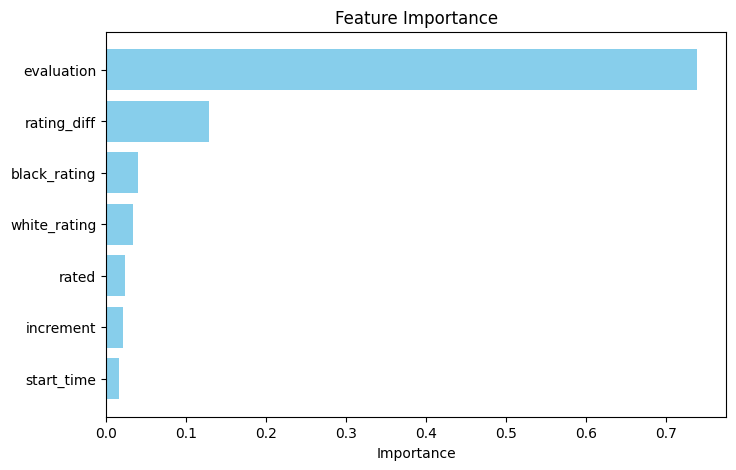

In [19]:
def feature_importance(best_model, X):
    """
    Calculate and plot feature importance

    Parameters
    ----------
    best_model : fitted classifier object
        The trained model.
    X : array-like
        Feature matrix.
    """

    importances = best_model.feature_importances_
    features = X.columns

    #Normalize importance
    importances = importances / importances.sum()

    # Put into a DataFrame for easy sorting
    feat_imp = pd.DataFrame({
        "Feature": features,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.barh(feat_imp["Feature"], feat_imp["Importance"], color="skyblue")
    plt.gca().invert_yaxis()  # Most important at the top
    plt.xlabel("Importance")
    plt.title("Feature Importance")
    plt.show()


feature_importance(fitted_model, X_train)

## Classification metrics

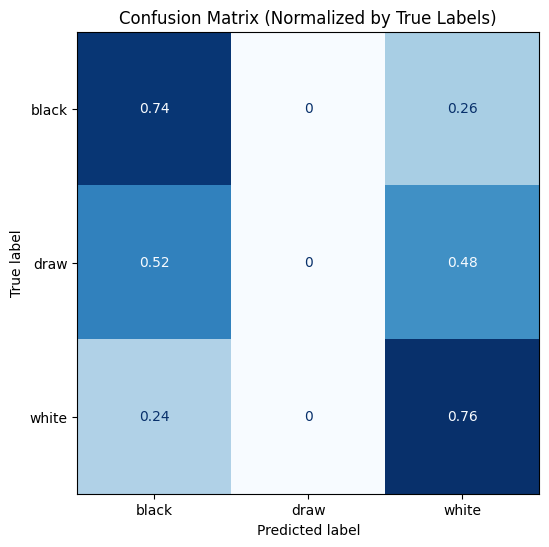


Classification Report:

              precision    recall  f1-score   support

       black       0.71      0.74      0.72      1249
        draw       0.00      0.00      0.00       144
       white       0.71      0.76      0.73      1256

    accuracy                           0.71      2649
   macro avg       0.47      0.50      0.49      2649
weighted avg       0.67      0.71      0.69      2649



/tmp/ipykernel_26286/1422908542.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="colorblind")


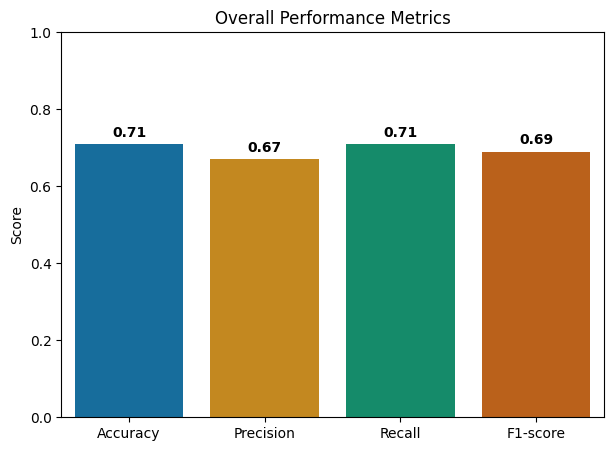

<Figure size 900x600 with 0 Axes>

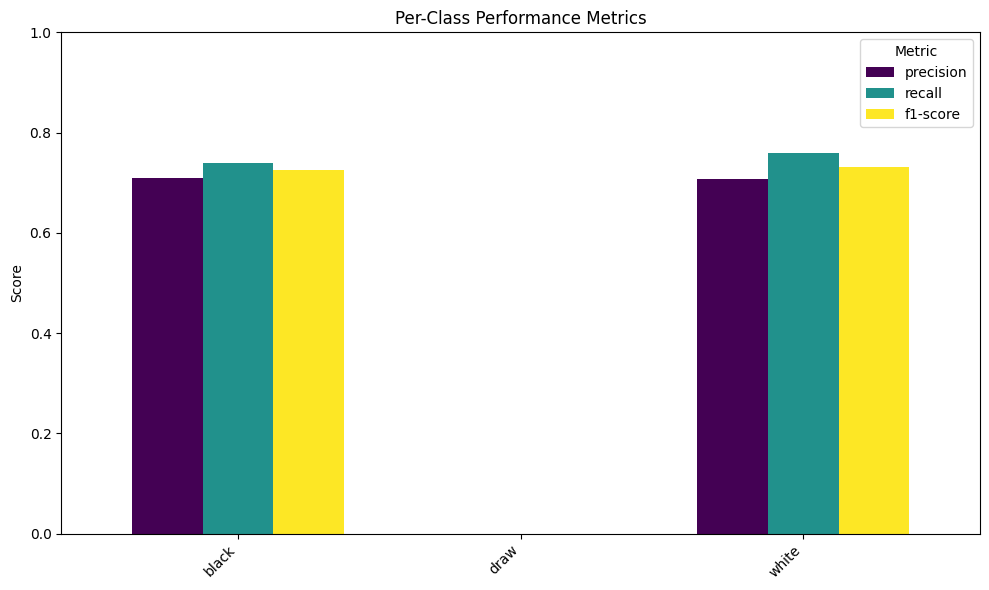

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


def classification_metrics(best_model, X, y, encoder):
    """
    Plot confusion matrix alongside overall and per-class classification metrics.

    Parameters

    best_model : fitted classifier object
        The trained model.
    X : array-like
        Feature matrix.
    y : array-like
        True labels.
    encoder : LabelEncoder
        The fitted label encoder.
    """
    # Predict encoded labels
    y_pred = best_model.predict(X)

    #Decode both true and predicted labels
    y_true_decoded = encoder.inverse_transform(y)
    y_pred_decoded = encoder.inverse_transform(y_pred)

    labels = encoder.classes_

    #Confusion Matrix
    cm = confusion_matrix(y_true_decoded, y_pred_decoded, labels=labels, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap='Blues', ax=ax, colorbar=False)
    plt.title("Confusion Matrix (Normalized by True Labels)")
    plt.show()

    #Classification Report
    print("\nClassification Report:\n")
    report = classification_report(y_true_decoded, y_pred_decoded, target_names=labels, output_dict=True, zero_division=0)
    print(classification_report(y_true_decoded, y_pred_decoded, target_names=labels, zero_division=0))

    #Convert to DataFrame for plotting
    report_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

     #Performance Metrics
    accuracy = accuracy_score(y_true_decoded, y_pred_decoded)
    precision = precision_score(y_true_decoded, y_pred_decoded, average='weighted', zero_division=0)
    recall = recall_score(y_true_decoded, y_pred_decoded, average='weighted', zero_division=0)
    f1 = f1_score(y_true_decoded, y_pred_decoded, average='weighted', zero_division=0)

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

    plt.figure(figsize=(7, 5))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="colorblind")
    plt.ylim(0, 1)
    plt.title("Overall Performance Metrics")
    plt.ylabel("Score")
    for i, v in enumerate(metrics.values()):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
    plt.show()

    #Per-class Metrics Plot
    plt.figure(figsize=(9, 6))
    report_df[['precision', 'recall', 'f1-score']].plot(
        kind='bar', figsize=(10, 6), colormap='viridis', width=0.75
    )
    plt.title("Per-Class Performance Metrics")
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.xticks(range(len(report_df)), report_df.index, rotation=45, ha='right')
    plt.legend(title="Metric")
    plt.tight_layout()
    plt.show()



classification_metrics(fitted_model, X_test, y_test, le)


## ROC curve

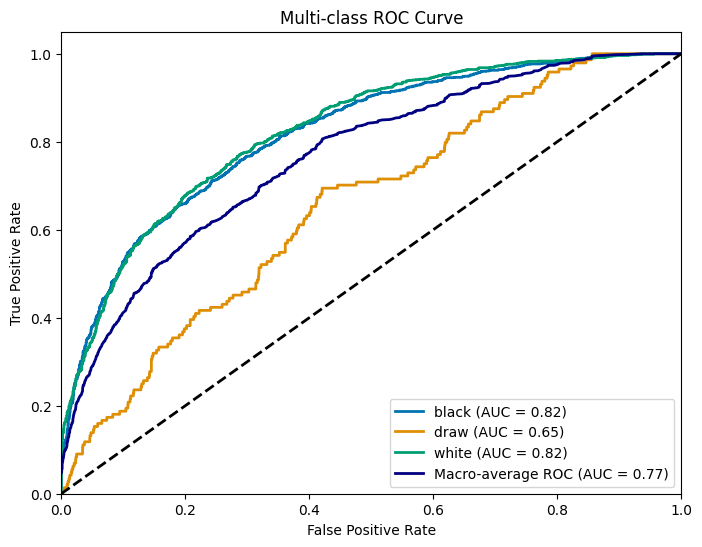

In [21]:
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.preprocessing import LabelEncoder, label_binarize

def plot_multiclass_roc(y_true, y_proba, model, label_encoder):
    """
    Plots ROC curves for multi-class classification.

    Parameters:

    y_true: encoded (numeric) labels
    y_prob: predicted probabilities (n_samples × n_classes)
    model: fitted classifier
    label_encoder: fitted LabelEncoder
    """
    # Use the encoder’s class order to ensure consistency
    classes = label_encoder.classes_
    n_classes = len(classes)

    # Binarize the true labels according to the class order
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Colorblind-friendly palette
    colors = sns.color_palette("colorblind", n_classes)

    plt.figure(figsize=(8, 6))

    # Per-class ROC curves
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color=colors[i], label=f'{cls} (AUC = {roc_auc:.2f})')

    # Macro-average ROC
    all_fpr = np.unique(
        np.concatenate([roc_curve(y_true_bin[:, i], y_proba[:, i])[0] for i in range(n_classes)])
    )
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= n_classes
    roc_auc_macro = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, color='navy', linestyle='-',
             label=f'Macro-average ROC (AUC = {roc_auc_macro:.2f})', lw=2)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_multiclass_roc(y_test, y_pred_proba, fitted_model, le)


## Precision Recall curve

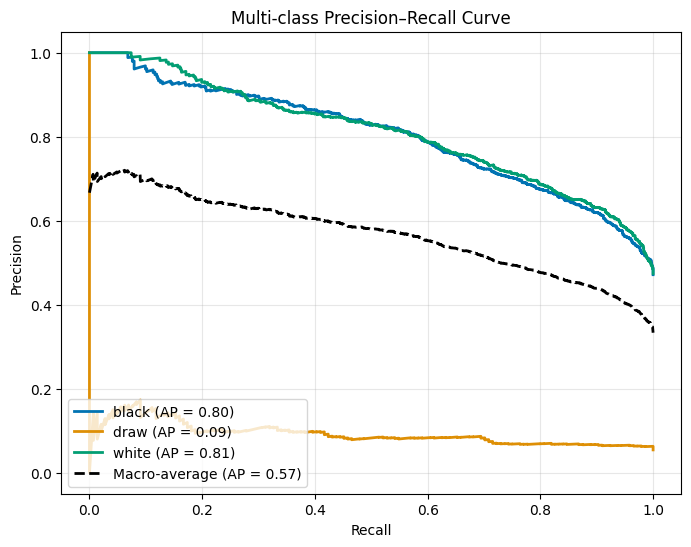

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(y_true, y_proba, model, label_encoder):
    """
    Plots precision–recall curves for multi-class classification.

    Parameters:
    - y_true: encoded (numeric) labels
    - y_prob: predicted probabilities (n_samples × n_classes)
    - model: fitted classifier
    - label_encoder: fitted LabelEncoder
    """
    classes = label_encoder.classes_
    n_classes = len(classes)

    # Binarize true labels using the encoder’s order
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Colorblind friendly palette
    colors = sns.color_palette("colorblind", n_classes)

    plt.figure(figsize=(8, 6))

    # Per-class PR curves
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_proba[:, i])
        plt.plot(
            recall, precision, lw=2, color=colors[i],
            label=f'{cls} (AP = {ap:.2f})'
        )

    # Macro-average curve
    all_recall = np.unique(np.concatenate([
        precision_recall_curve(y_true_bin[:, i], y_proba[:, i])[1] for i in range(n_classes)
    ]))
    mean_precision = np.zeros_like(all_recall)
    for i in range(n_classes):
        p, r, _ = precision_recall_curve(y_true_bin[:, i], y_proba[:, i])
        mean_precision += np.interp(all_recall, r[::-1], p[::-1])
    mean_precision /= n_classes
    mean_ap = np.mean([
        average_precision_score(y_true_bin[:, i], y_proba[:, i]) for i in range(n_classes)
    ])
    plt.plot(
        all_recall, mean_precision,
        color='black', linestyle='--', lw=2,
        label=f'Macro-average (AP = {mean_ap:.2f})'
    )

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multi-class Precision–Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_precision_recall_curve(y_test, y_pred_proba, fitted_model, le)

# Reruns

I want to try to get some predictions of the draw class, so I will make a pipeline and try some approaches to address the imbalancing problem

## Oversampling

Shape of Data (20%)
X_train shape :  (10592, 7)
y_train shape :  (10592,)
X_test shape :  (2649, 7)
y_test shape :  (2649,)
Trial 0 finished with best value: 0.5568 and parameters: {'model': 'RandomForest', 'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4, 'bootstrap': True}
Trial 1 finished with best value: 0.5630 and parameters: {'model': 'XGBoost', 'reg_alpha': 512.1922633857766, 'reg_lambda': 812.6209616521135, 'subsample': 0.8062630334146941, 'colsample_bytree': 0.8608776587158997, 'learning_rate': 0.0946440597694836}
Trial 12 finished with best value: 0.5632 and parameters: {'model': 'XGBoost', 'reg_alpha': 310.1271894103483, 'reg_lambda': 697.260282381917, 'subsample': 0.7604317148311178, 'colsample_bytree': 0.7477706771937483, 'learning_rate': 0.08274042090033526}
Trial 23 finished with best value: 0.5639 and parameters: {'model': 'XGBoost', 'reg_alpha': 126.48912679780685, 'reg_lambda': 983.7149164138496, 'subsample': 0.737

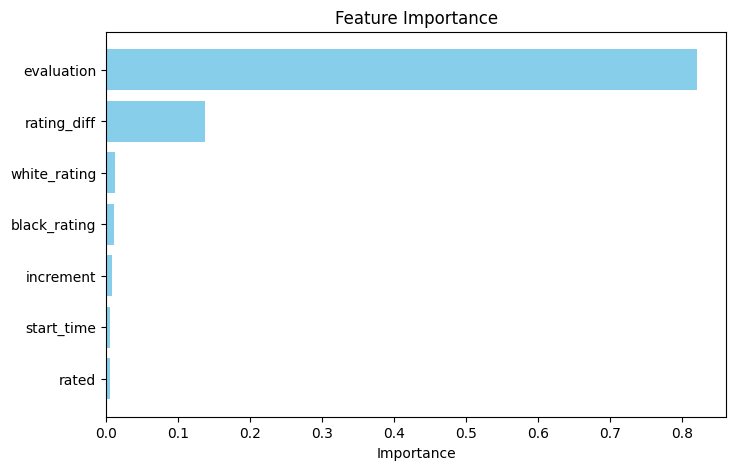

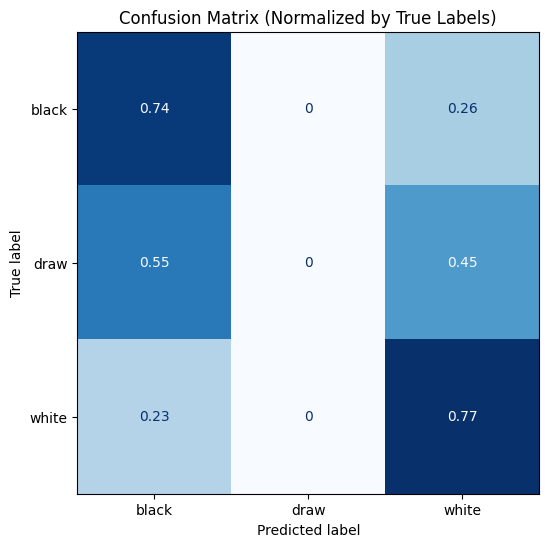


Classification Report:

              precision    recall  f1-score   support

       black       0.71      0.74      0.72      1249
        draw       0.00      0.00      0.00       144
       white       0.71      0.77      0.74      1256

    accuracy                           0.71      2649
   macro avg       0.47      0.50      0.49      2649
weighted avg       0.67      0.71      0.69      2649



/tmp/ipykernel_26286/1422908542.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="colorblind")


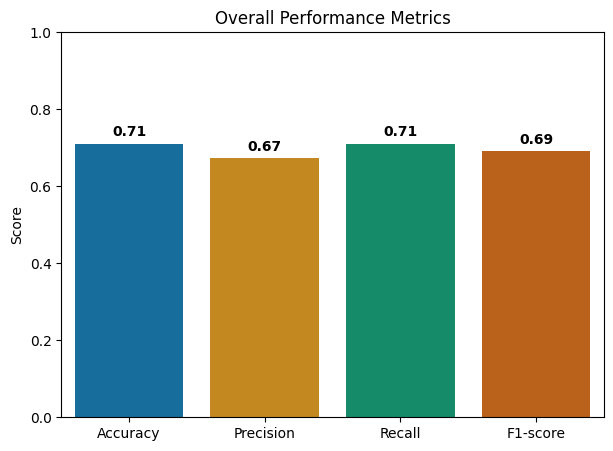

<Figure size 900x600 with 0 Axes>

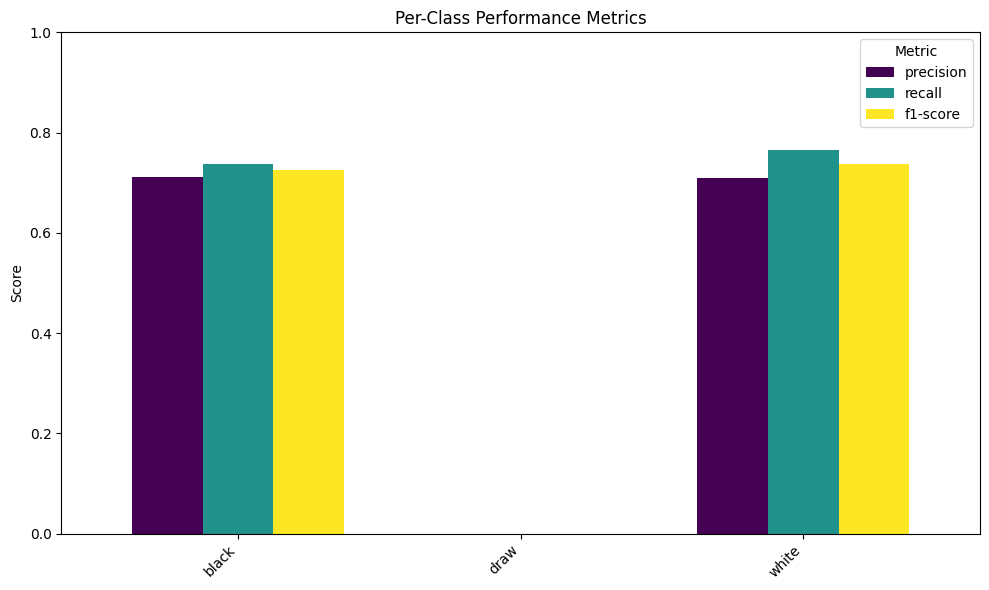

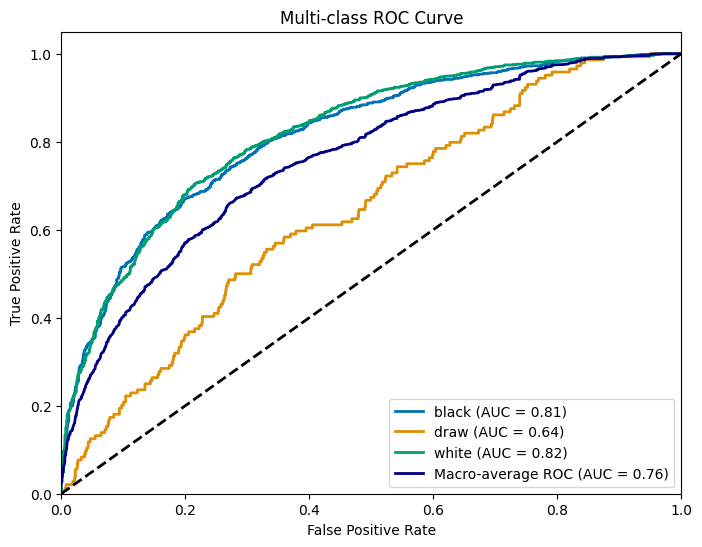

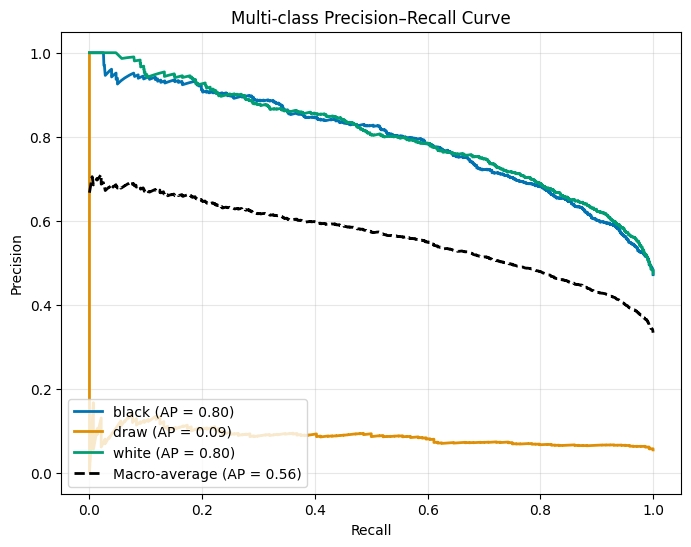

In [23]:
def run_model(df, imbalance = None):
    """
    Full pipeline to train, evaluate, and visualize a machine learning classifier.

    Parameters

    df : pandas.DataFrame
        Input dataframe containing features and target variable.
    imbalance : str or None, optional
        Method to handle class imbalance ('balancing' to apply random oversampler of minority class,
        'weights' to apply classification weights, or None).

    Returns

    fitted_model_fun : classifier object
        The trained model.
    X_train_fun, X_test_fun : array-like
        Training and test feature matrices.
    y_train_fun, y_test_fun : array-like
        Training and test target vectors (encoded if needed).
    y_pred_fun : array-like
        Predicted class labels for the test set.
    y_pred_proba_fun : array-like
        Predicted probabilities for the test set.
    le_fun : LabelEncoder
        Fitted label encoder to map class labels back to original values.
    """

    X_train_fun, X_test_fun, y_train_fun, y_test_fun = define_train_test(df)
    y_train_fun, y_test_fun, le_fun = encode(y_train_fun, y_test_fun)
    optimized_fun = optimize_model(X_train_fun, y_train_fun, class_imbalance=imbalance)
    fitted_model_fun, y_pred_fun, y_pred_proba_fun = model_predict(optimized_fun, X_train_fun, X_test_fun, y_train_fun, y_test_fun)
    feature_importance(fitted_model_fun, X_train_fun)
    classification_metrics(fitted_model_fun, X_test_fun, y_test_fun, le_fun)
    plot_multiclass_roc(y_test_fun, y_pred_proba_fun, fitted_model_fun, le_fun)
    plot_precision_recall_curve(y_test_fun, y_pred_proba_fun, fitted_model_fun, le_fun)

    return fitted_model_fun, X_train_fun, X_test_fun, y_train_fun, y_test_fun, y_pred_fun, y_pred_proba_fun, le_fun

fitted_model_v2, X_train_v2, X_test_v2, y_train_v2, y_test_v2, y_pred_v2, y_pred_proba_v2, le_v2 = run_model(games_selected, imbalance = 'balancing')

Metrics are barely affected

## Class weights

In [ ]:
fitted_model_v3, X_train_v3, X_test_v3, y_train_v3, y_test_v3, y_pred_v3, y_pred_proba_v3, le_v3 = run_model(games_selected, imbalance = 'weights')

Shape of Data (20%)
X_train shape :  (10592, 7)
y_train shape :  (10592,)
X_test shape :  (2649, 7)
y_test shape :  (2649,)
Trial 0 finished with best value: 0.5570 and parameters: {'model': 'RandomForest', 'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4, 'bootstrap': True}
Trial 2 finished with best value: 0.5604 and parameters: {'model': 'RandomForest', 'n_estimators': 78, 'max_depth': 6, 'min_samples_split': 24, 'min_samples_leaf': 12, 'max_features': 3, 'bootstrap': True}
Trial 17 finished with best value: 0.5611 and parameters: {'model': 'RandomForest', 'n_estimators': 108, 'max_depth': 7, 'min_samples_split': 24, 'min_samples_leaf': 5, 'max_features': 3, 'bootstrap': True}
Trial 24 finished with best value: 0.5624 and parameters: {'model': 'Light Gradient-Boosting Machine', 'reg_alpha': 244.28810466084323, 'reg_lambda': 267.9879412417608, 'subsample': 0.706275763542806, 'colsample_bytree': 0.7402854241118964, 'learning_rate':

## Metagame data only

Now I want to see the performance with pure metagame data

In [ ]:
#Remove evaluatio
games_selected_metadata = games_selected.drop(['evaluation'], axis = 1)
games_selected_metadata.head()

In [ ]:
fitted_model_v4, X_train_v4, X_test_v4, y_train_v4, y_test_v4, y_pred_v4, y_pred_proba_v4, le_v4 = run_model(games_selected_metadata)